# Implementation of Neural Network Classification on NSL-KDD Dataset
Using Method Described in *"Traffic Analysis Based Identification of Attacks"* found [here](http://cecs.louisville.edu/ry/Traffic.pdf).

Uses scikit-learn MLP learner to classify [NSL-KDD dataset](http://www.unb.ca/cic/research/datasets/nsl.html) and analyze results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import MLPClassifier

## Data Preprocessing
Define a data loading function, categorical variables are converted into numerical using categorical codes.

In [46]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def load_data(file_path, reduce = False, cols=None):
    
    data = pd.read_csv(file_path)
    
 
    
    #Issues with values on columns 14 and 15
    #data.replace("NaN" ,0,inplace=True)
    #data.replace("Infinity", 0, inplace=True)
    
    data.dropna(inplace=True)
    
    """
    for col in data.columns:
        if (sum(data[col] =='NaN') > 0):
            print("Error : still NaN values in data \n")
        
        if(sum(data[col] =='Infinity') >0):
            print("Error : still Infinity values in data \n")
        
    """ 
    
    #Reduce the number of benign frames to increase recall
    
    if reduce :
        L = []
        count = 0
        for i, row in data.iterrows():
            if  count ==10 :                
                count = 0
            elif  row[' Label']  == "BENIGN":
                ++count 
                L.append(i)
        data.drop(L,inplace=True)

    
  
    for col in data.columns: 
        if(col == " Label") : print("Ignore column Label")
        
        else : data = data.loc[(data[col] < np.finfo(np.float64).max )] 
        
    # Shuffle data

    data = data.sample(frac=1).reset_index(drop=True)
      
    labels = data[' Label']        #VILAIN IDS2017 POUR L'ESPACE DEVANT DANS ' LABEL'. Bien profond hein.
    data.drop(' Label', axis=1, inplace=True)
    
    #data.iloc[:] = minmax_scale(data.iloc[:])
    
        
    return [data, labels]

## Slicing IDS 2017 to Training Set and Test Set

In [47]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def load_slice_data(file_path, cols=None):
    
    data = pd.read_csv(file_path)
    
 
    
    #Issues with values on columns 14 and 15
    #data.replace("NaN" ,0,inplace=True)
    #data.replace("Infinity", 0, inplace=True)
    
    data.dropna(inplace=True)
    
    """
    for col in data.columns:
        if (sum(data[col] =='NaN') > 0):
            print("Error : still NaN values in data \n")
        
        if(sum(data[col] =='Infinity') >0):
            print("Error : still Infinity values in data \n")
        
    """ 
    
  
    for col in data.columns: 
        if(col == " Label") : print("Ignore column Label")
        
        else : data = data.loc[(data[col] < np.finfo(np.float64).max )] 
    
    data = data.sample(frac=1).reset_index(drop=True)

    
      
    #labels = data[' Label']        #VILAIN IDS2017 POUR L'ESPACE DEVANT DANS ' LABEL'. Bien profond hein.
    #data.drop(' Label', axis=1, inplace=True)
    
    #data.iloc[:] = minmax_scale(data.iloc[:])
    
        
    return data

In [21]:
train_data = load_slice_data('data/concat.csv')


Ignorer colonne Label


In [22]:
print(train_data.shape)

(2827876, 79)


In [23]:

chunk = int (train_data.shape[0]*75/100)  #ratio = 75 %  /  25% 
train_set =train_data.iloc[:chunk,:]
test_set = train_data.iloc[chunk:,:]

print(train_set.shape)
print(test_set.shape)


test_set.head()

(2120907, 79)
(706969, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2120907,80,115898178,16,14,656,934,572,0,41.000000,141.607909,...,20,46839.545455,33170.393119,146852,36791,1.000774e+07,1.938980e+04,10025769,9952393,BENIGN
2120908,53,173,2,2,72,104,36,36,36.000000,0.000000,...,20,0.000000,0.000000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
2120909,57253,92141034,7,9,11607,62,4380,0,1658.142857,1762.272815,...,20,39157.000000,0.000000,39157,39157,4.600000e+07,4.850000e+07,80300000,11700000,BENIGN
2120910,53,23762,2,2,134,296,67,67,67.000000,0.000000,...,20,0.000000,0.000000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
2120911,50785,14,1,1,0,0,0,0,0.000000,0.000000,...,32,0.000000,0.000000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN


## Exporting dataframes to csv files

In [24]:
train_set.to_csv("train_IDS2017.csv", index=False)
test_set.to_csv("test_IDS2017.csv", index=False)

## Reducing the number of benign frames

In [ ]:
def load_reduce_data(file_path, reduce = False, cols=None):
    
    data = pd.read_csv(file_path)
    
 
    
    #Issues with values on columns 14 and 15
    #data.replace("NaN" ,0,inplace=True)
    #data.replace("Infinity", 0, inplace=True)
    
    data.dropna(inplace=True)
    
    """
    for col in data.columns:
        if (sum(data[col] =='NaN') > 0):
            print("Error : still NaN values in data \n")
        
        if(sum(data[col] =='Infinity') >0):
            print("Error : still Infinity values in data \n")
        
    """ 
    
    #Reduce the number of benign frames to increase recall
    
    if reduce :
        L = []
        count = 0
        for i, row in data.iterrows():
            if  count ==10 :                
                count = 0
            elif  row[' Label']  == "BENIGN":
                ++count 
                L.append(i)
        data.drop(L,inplace=True)

    
  
    for col in data.columns: 
        if(col == " Label") : print("Ignore column Label")
        
        else : data = data.loc[(data[col] < np.finfo(np.float64).max )] 
        
    # Shuffle data

    data = data.sample(frac=1).reset_index(drop=True)
      
    labels = data[' Label']        #VILAIN IDS2017 POUR L'ESPACE DEVANT DANS ' LABEL'. Bien profond hein.
    data.drop(' Label', axis=1, inplace=True)
    
    #data.iloc[:] = minmax_scale(data.iloc[:])
    
        
    return [data, labels]

## Neural Network Training and Testing
Define a function that trains the model and evaluates it on the test data, outputs accuracy on the training and test sets.

In [36]:
def train_clf(train_data, train_labels):
    bin_labels = train_labels.apply(lambda x: x if x =='BENIGN' else 'ANOMALY')
    clf = MLPClassifier(hidden_layer_sizes=(79,3), alpha=.7,
                        beta_1=.8, beta_2=.8)
    clf.fit(train_data, bin_labels)
    
    train_preds = clf.predict(train_data)
    
    TP = sum((train_preds == bin_labels) & (bin_labels == 'ANOMALY'))
    FP = sum((train_preds != bin_labels) & (bin_labels == 'BENIGN'))
    
    TN = sum((train_preds == bin_labels) & (bin_labels == 'BENIGN'))
    FN = sum((train_preds != bin_labels) & (bin_labels == 'ANOMALY'))
    
    train_acc = sum(train_preds == bin_labels)/len(train_preds)
    
    train_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    train_recall = TP/(TP + FN) #Note : TN + FN = sum(train_preds != bin_labels)
    
    train_f = 2 * train_precision * train_recall /(train_precision + train_recall)
    
    print("Accuracy on training set: {0:1%}".format(train_acc))
    print("Precision on training set: {0:1%}".format(train_precision))
    print("Recall on training set: {0:1%}".format(train_recall))
    print("F measure on training set: {0:1%}".format(train_f))

    return clf

In [37]:
def test_clf(test_data, test_labels, clf):
    bin_labels = test_labels.apply(lambda x: x if x =='BENIGN' else 'ANOMALY')
    test_preds = clf.predict(test_data)
    
    TP = sum((test_preds == bin_labels) & (bin_labels == 'ANOMALY'))
    FP = sum((test_preds != bin_labels) & (bin_labels == 'BENIGN'))
    
    TN = sum((test_preds == bin_labels) & (bin_labels == 'BENIGN'))
    FN = sum((test_preds != bin_labels) & (bin_labels == 'ANOMALY'))
    
    test_acc = sum(test_preds == bin_labels)/len(test_preds)
    
    test_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    test_recall = TP/(TP + FN) #Note : TN + FN = sum(train_preds != bin_labels)
    
    test_f = 2 * test_precision * test_recall /(test_precision + test_recall)
    print("Accuracy on test set: {0:1%}".format(test_acc))
    print("Precision on test set: {0:1%}".format(test_precision))
    print("Recall on test set: {0:1%}".format(test_recall))
    print("F measure on test set: {0:1%}".format(test_f))
    return test_preds

# Training Classifier

In [48]:
train_data, train_labels = load_data('train_IDS2017.csv',reduce=True)
train_data.head()

Ignore column Label


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80,3,2,0,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
1,3851,55,1,1,0,6,0,0,0.000000,0.000000,...,0,40,0.0,0.0,0,0,0.0,0.0,0,0
2,80,99413104,8,7,326,11595,326,0,40.750000,115.258405,...,1,32,1007.0,0.0,1007,1007,99400000.0,0.0,99400000,99400000
3,80,101675545,9,6,372,11595,372,0,41.333333,124.000000,...,1,32,1004.0,0.0,1004,1004,98700000.0,0.0,98700000,98700000
4,80,98725703,6,5,336,11595,336,0,56.000000,137.171426,...,1,32,2.0,0.0,2,2,98700000.0,0.0,98700000,98700000


In [49]:
print(train_data.shape)

(417290, 78)


In [50]:
clf = train_clf((train_data), train_labels)


Accuracy on training set: 100.000000%
Precision on training set: 100.000000%
Recall on training set: 100.000000%
F measure on training set: 100.000000%


# Testing

In [51]:
test_data, test_labels = load_data('test_IDS2017.csv',reduce=True)
test_data.head()

Ignore column Label


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80,4,2,0,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
1,80,908678,3,5,26,11607,20,0,8.666667,10.263203,...,2,20,0.0,0.0,0,0,0.0,0.0,0,0
2,1126,58,1,1,0,6,0,0,0.000000,0.000000,...,0,40,0.0,0.0,0,0,0.0,0.0,0,0
3,80,99420817,9,5,354,11595,354,0,39.333333,118.000000,...,1,32,990.0,0.0,990,990,99300000.0,0.0,99300000,99300000
4,10215,57,1,1,0,6,0,0,0.000000,0.000000,...,0,40,0.0,0.0,0,0,0.0,0.0,0,0


In [52]:
test_preds = test_clf(test_data, test_labels, clf)

Accuracy on test set: 100.000000%
Precision on test set: 100.000000%
Recall on test set: 100.000000%
F measure on test set: 100.000000%


In [29]:
ATTACKS = {
    'BENIGN': 'BENIGN',

    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',

    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',

    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

test_cat_labels = test_labels.apply(lambda x: ATTACKS[x])
cats = {'U2R':[0, 0], 'DoS':[0, 0], 'R2L':[0, 0], 'Probe':[0, 0], 'BENIGN':[0, 0]}
for cat, pred in zip(test_cat_labels, test_preds):
    cats[cat][pred=='BENIGN'] += 1
print(cats)

for key, values in cats.items():
    print('\n' + key)
    total = sum(values)
    print('Total rows: {}'.format(total))
    if key == 'BENIGN':
        correct = values[1]
    else:
        correct = values[0]
    print('Percent correctly classified: {:.1%}'.format(correct/total))

KeyError: 'PortScan'

NameError: name 'cats' is not defined

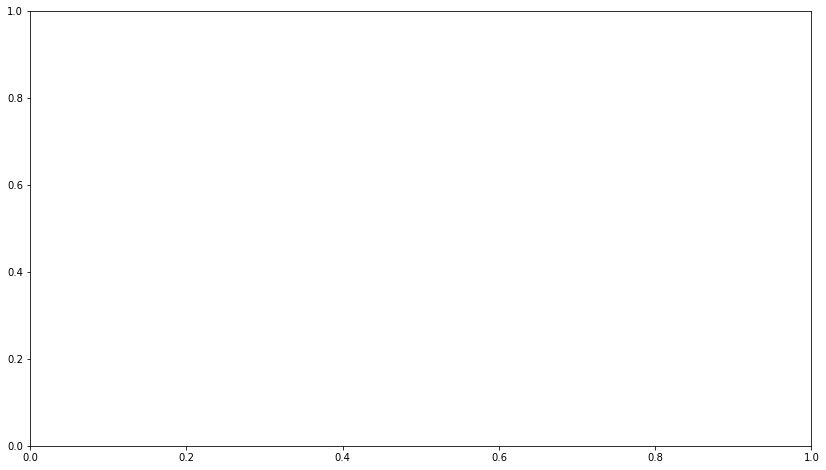

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ind = np.arange(4)
width = .25
fig, ax = plt.subplots(figsize=(14,8))
del cats['normal']
anoms = [values[0] for key, values in cats.items()]
norms = [values[1] for key, values in cats.items()]
rect1 = ax.bar(ind, anoms, width, color='crimson')
rect2 = ax.bar(ind + width, norms, width, color='grey')
ax.set_ylabel('Number of Rows')
ax.set_title('Accuracy by Category')
ax.set_xlabel('Categories')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(cats.keys())
ax.legend((rect1[0], rect2[0]), ('Anomaly', 'Normal'))

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rect1, ax)
autolabel(rect2, ax)

__Probe__ and __DoS__ have the highest accuracy, while __U2R__ is about even. __R2L__ classification is abysmal, however __normal__ labeling is almost _100%_, which means this classifier has a lot more false negatives than false positives.